<a href="https://colab.research.google.com/github/fireHedgehog/music-intrument-OvA-model/blob/main/open-mic/train_open_mic_in_res_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. mount the google drive






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

# Load the HDF5 file and create X_train
def load_hdf5_file(hdf5_file_path):
    with h5py.File(hdf5_file_path, 'r') as hdf5_file:
        X_train = []
        sample_keys = []
        for sample_key in hdf5_file.keys():
            spectrogram = hdf5_file[sample_key][:]
            X_train.append(spectrogram)
            sample_keys.append(sample_key)
    return X_train, sample_keys

In [ ]:
# Load the metadata file
metadata_file = '/content/drive/My Drive/datasets/openmic-2018/openmic-2018/openmic-2018-aggregated-labels.csv'
metadata = pd.read_csv(metadata_file)

In [ ]:
# Load the training HDF5 file
train_hdf5_file_path = '/content/drive/My Drive/datasets/openmic-2018/train_spectrograms.h5'
X_train, sample_keys = load_hdf5_file(train_hdf5_file_path)

In [ ]:
import numpy as np

# Convert X_train to a numpy array
X_train = np.array(X_train)

# Example usage
print("x_train shape:", X_train.shape)
print("x_train[0]:", X_train[0])

x_train shape: (14915, 218, 800)
x_train[0]: [[0.10258293 0.14368583 0.21555336 ... 0.60530014 0.62167129 0.63103437]
 [0.17451057 0.22862051 0.32323059 ... 0.65854224 0.67061877 0.67752564]
 [0.22467108 0.29214791 0.41012971 ... 0.86246766 0.8555632  0.85161436]
 ...
 [0.38949594 0.39086323 0.39325392 ... 0.38257781 0.37605065 0.37231759]
 [0.38949594 0.39086323 0.39325392 ... 0.38257781 0.37605065 0.37231759]
 [0.38949594 0.39086323 0.39325392 ... 0.38257781 0.37605065 0.37231759]]


In [ ]:
# Expand dimensions of x_train to add the channel dimension
X_train = np.expand_dims(X_train, axis=-1)

# Example usage
# print("x_train shape:", X_train.shape)
# print("x_train[0]:", X_train[0])

In [ ]:
# Extract and weight y_train
y_train_list = []
weights_list = []
for sample_key in sample_keys:
    sample_metadata = metadata[metadata["sample_key"] == sample_key]
    labels = sample_metadata[sample_metadata["relevance"] > 0.0]["instrument"].tolist()
    relevance_scores = sample_metadata[sample_metadata["relevance"] > 0.0]["relevance"].tolist()
    y_train_list.append(set(labels))
    if relevance_scores:
        weights_list.append(np.mean(relevance_scores))
    else:
        weights_list.append(1.0)  # Default weight if no relevance score

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train_list)

# Example usage
print("X_train shape:", X_train.shape)
print("X_train[0] shape:", X_train[0].shape if len(X_train) > 0 else "No data")
print("y_train shape:", y_train.shape)
print("Classes:", mlb.classes_)

X_train shape: (14915, 218, 800, 1)
X_train[0] shape: (218, 800, 1)
y_train shape: (14915, 20)
Classes: ['accordion' 'banjo' 'bass' 'cello' 'clarinet' 'cymbals' 'drums' 'flute'
 'guitar' 'mallet_percussion' 'mandolin' 'organ' 'piano' 'saxophone'
 'synthesizer' 'trombone' 'trumpet' 'ukulele' 'violin' 'voice']


In [ ]:
# Load the testing HDF5 file
test_hdf5_file_path = '/content/drive/My Drive/datasets/openmic-2018/test_spectrograms.h5'
X_test, test_sample_keys = load_hdf5_file(test_hdf5_file_path)

# Convert X_test to a numpy array
X_test = np.array(X_test)


print("X_test shape:", X_test.shape)
print("X_test[0] shape:", X_test[0].shape if len(X_test) > 0 else "No data")

X_test shape: (5085, 218, 800)
X_test[0] shape: (218, 800)


In [ ]:
# Expand dimensions of X_test to add the channel dimension
X_test = np.expand_dims(X_test, axis=-1)

# Example usage
# print("X_test shape:", X_test.shape)
# print("X_test[0]:", X_test[0])

In [ ]:
# Extract and binarize y_test using the fitted mlb
y_test_list = []
for sample_key in test_sample_keys:
    sample_metadata = metadata[metadata["sample_key"] == sample_key]
    labels = sample_metadata[sample_metadata["relevance"] > 0.0]["instrument"].tolist()
    y_test_list.append(set(labels))

# reuse the training one
y_test = mlb.transform(y_test_list)
print("y_test shape:", y_test.shape)

y_test shape: (5085, 20)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Multiply, Add, Activation,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

In [ ]:
# Modify channel_attention and coordinate_attention to return attention maps
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    attention_map = Multiply()([input_feature, cbam_feature])
    return attention_map, cbam_feature

In [ ]:
def coordinate_attention(inputs, reduction_ratio=8):
    def h_swish(x):
        return x * tf.nn.relu6(x + 3) / 6

    _, h, w, c = inputs.shape

    h_avg_pool = tf.reduce_mean(inputs, axis=2, keepdims=True)
    w_avg_pool = tf.reduce_mean(inputs, axis=1, keepdims=True)

    h_avg_pool = tf.transpose(h_avg_pool, [0, 2, 1, 3])
    h_avg_pool = Conv2D(filters=c // reduction_ratio, kernel_size=1, activation=h_swish)(h_avg_pool)
    h_avg_pool = Conv2D(filters=c, kernel_size=1, activation='sigmoid')(h_avg_pool)
    h_avg_pool = tf.transpose(h_avg_pool, [0, 2, 1, 3])

    w_avg_pool = Conv2D(filters=c // reduction_ratio, kernel_size=1, activation=h_swish)(w_avg_pool)
    w_avg_pool = Conv2D(filters=c, kernel_size=1, activation='sigmoid')(w_avg_pool)

    attention_map = inputs * h_avg_pool * w_avg_pool
    return attention_map, h_avg_pool, w_avg_pool

In [ ]:
from tensorflow.keras.layers import Add, Activation

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # If the input and output shapes do not match, use a convolution to match them
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [ ]:
from re import X

"""
def create_training_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)

    # Apply channel attention
    x, _ = channel_attention(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Apply coordinate attention
    x, _, _ = coordinate_attention(x)

    # Additional pooling layer to reduce dimensionality
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)  # Use sigmoid for multi-label classification

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

"""

def create_training_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = residual_block(inputs, 32)
    x = MaxPooling2D(pool_size=(2, 2))(x)
     # print(f"Shape after MaxPooling2D: {x.shape}")

    x, _, _ = coordinate_attention(x) # early attention

    x = residual_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # print(f"Shape after MaxPooling2D: {x.shape}")

    x, _, _ = coordinate_attention(x) # mid attention

    x = residual_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
     # print(f"Shape after MaxPooling2D: {x.shape}")

    x = residual_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)
     # print(f"Shape after MaxPooling2D: {x.shape}")

    x, _ = channel_attention(x)
     # print(f"Shape after channel_attention: {x.shape}")
    x, _, _ = coordinate_attention(x)
     # print(f"Shape after coordinate_attention: {x.shape}")

    x = Flatten()(x)
     # print(f"Shape after Flatten: {x.shape}")
    x = Dense(512, activation='relu')(x)
     # print(f"Shape after Dense(512): {x.shape}")
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)  # Use sigmoid for multi-label classification
     # print(f"Shape after Dense(output): {outputs.shape}")

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=[])
    return model

input_shape = (218, 800, 1)
num_classes = y_train.shape[1]

print(f"Input shape: {input_shape}")

print(f"Number of classes: {num_classes}")
training_model = create_training_model(input_shape, num_classes)

training_model.summary()


Input shape: (218, 800, 1)
Number of classes: 20
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 218, 800, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 218, 800, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 218, 800, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 218, 800,

In [ ]:
# better to shuffle the data
from sklearn.utils import shuffle
weights_array = np.array(weights_list)

In [ ]:
# Ensure weights match the number of samples and one-hot encoding
X_train, y_train, weights_array = shuffle(X_train, y_train, weights_array, random_state=36)

In [ ]:

"""
from tensorflow.keras.utils import Sequence
import numpy as np

class AudioDataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Apply augmentations
        augmented_batch_x = np.array([self.augment(spec) for spec in batch_x])

        return augmented_batch_x, batch_y

    def augment(self, spectrogram):
        # Time stretching
        stretch_factor = np.random.uniform(0.8, 1.2)
        time_stretched = np.interp(np.linspace(0, 1, spectrogram.shape[1]),
                                   np.linspace(0, 1, int(spectrogram.shape[1] * stretch_factor)),
                                   spectrogram)

        # Frequency masking
        freq_mask_param = 20
        num_masks = 2
        for _ in range(num_masks):
            f0 = np.random.randint(0, spectrogram.shape[0] - freq_mask_param)
            time_stretched[f0:f0+freq_mask_param, :] = 0

        return time_stretched

# Split the data for validation
val_split = 0.2
split_idx = int(len(X_train) * (1 - val_split))
X_train_split, X_val = X_train[:split_idx], X_train[split_idx:]
y_train_split, y_val = y_train[:split_idx], y_train[split_idx:]

# Create the data generator for training data only
train_generator = AudioDataGenerator(X_train_split, y_train_split, batch_size=32)

steps_per_epoch = len(X_train_split) // 32  # batch size is

history = training_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_reducer]
)


"""

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stopping = EarlyStopping(patience=80, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(factor=0.1, patience=40)

history = training_model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    sample_weight=weights_array,
    callbacks=[early_stopping, lr_reducer]
)

# Save the model
model_save_path = '/content/drive/My Drive/datasets/openmic-2018/model_with_attention.tf'
training_model.save(model_save_path)

# Save the training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/datasets/openmic-2018/training_history_with_attention.csv', index=False)

print("Model and training history saved successfully.")

Epoch 1/500
373/373 [==============================] - 109s 221ms/step - loss: 0.1865 - accuracy: 0.1623 - val_loss: 0.3626 - val_accuracy: 0.0335 - lr: 0.0010
Epoch 2/500
373/373 [==============================] - 64s 172ms/step - loss: 0.1349 - accuracy: 0.2587 - val_loss: 0.1257 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 3/500
373/373 [==============================] - 64s 172ms/step - loss: 0.1186 - accuracy: 0.3196 - val_loss: 0.1184 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 4/500
373/373 [==============================] - 64s 172ms/step - loss: 0.1042 - accuracy: 0.3752 - val_loss: 0.1175 - val_accuracy: 0.3248 - lr: 0.0010
Epoch 5/500
373/373 [==============================] - 64s 172ms/step - loss: 0.0906 - accuracy: 0.4201 - val_loss: 0.1052 - val_accuracy: 0.3671 - lr: 0.0010
Epoch 6/500
373/373 [==============================] - 64s 172ms/step - loss: 0.0750 - accuracy: 0.4735 - val_loss: 0.1094 - val_accuracy: 0.3543 - lr: 0.0010
Epoch 7/500
373/373 [========================

In [ ]:
# Load the model
# import tensorflow as tf
# model_path = '/content/drive/My Drive/datasets/openmic-2018/model_with_attention.tf'
# training_model = tf.keras.models.load_model(model_path)

In [ ]:
from sklearn.metrics import accuracy_score, hamming_loss, classification_report, precision_recall_fscore_support

label_dict = {"accordion": 0, "banjo": 1, "bass": 2, "cello": 3, "clarinet": 4, "cymbals": 5, "drums": 6, "flute": 7, "guitar": 8, "mallet_percussion": 9, "mandolin": 10, "organ": 11, "piano": 12, "saxophone": 13, "synthesizer": 14, "trombone": 15, "trumpet": 16, "ukulele": 17, "violin": 18, "voice": 19}
# Step 1: Extract and sort class names based on their label values
target_names = [key for key, value in sorted(label_dict.items(), key=lambda item: item[1])]

# Predict the labels for the test set
y_pred = training_model.predict(X_test) # [:5]
y_pred_binary = (y_pred >= 0.50).astype(int)

small_true = y_test # [:5]

# Calculate Exact Match Ratio (EMR)
def exact_match_ratio(y_true, y_pred):
    return np.mean([np.array_equal(y_true[i], y_pred[i]) for i in range(len(y_true))])

emr = exact_match_ratio(small_true, y_pred_binary)
hl = hamming_loss(small_true, y_pred_binary)
# accuracy = accuracy_score(small_true, y_pred_binary)

# Calculate mean average precision (mAP)
precision, recall, f1, _ = precision_recall_fscore_support(small_true, y_pred_binary, average=None)
mean_average_precision = precision.mean()

print(f"Hamming Loss: {hl}")
print(classification_report(small_true, y_pred_binary, target_names=target_names))

print(f"Exact Match Ratio (EMR): {emr}")
print(f"Mean Average Precision (mAP): {mean_average_precision}")

159/159 [==============================] - 7s 43ms/step
Hamming Loss: 0.05511307767944936
                   precision    recall  f1-score   support

        accordion       1.00      0.01      0.03       233
            banjo       1.00      0.04      0.07       244
             bass       0.72      0.21      0.33       226
            cello       0.80      0.05      0.10       302
         clarinet       0.80      0.14      0.23       321
          cymbals       0.72      0.38      0.50       317
            drums       0.78      0.22      0.35       311
            flute       0.74      0.15      0.25       328
           guitar       0.73      0.18      0.29       315
mallet_percussion       0.63      0.18      0.28       280
         mandolin       0.94      0.10      0.18       329
            organ       0.75      0.08      0.15       221
            piano       0.92      0.37      0.53       304
        saxophone       0.77      0.20      0.32       389
      synthesizer       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def exact_match_ratio(y_true_list, y_pred_binary, mlb):
    # Convert one-hot encoded predictions back to multi-label format
    y_pred_labels = mlb.inverse_transform(y_pred_binary)

    # Calculate exact match ratio
    exact_matches = sum(1 for true, pred in zip(y_true_list, y_pred_labels) if set(true) == set(pred))
    return exact_matches / len(y_true_list)


emr = exact_match_ratio(y_test_list, y_pred_binary, mlb)
print(f"Exact Match Ratio (EMR): {emr}")

Exact Match Ratio (EMR): 0.27984267453294004


In [ ]:
# Save the test sample keys, true labels, and predicted labels to a DataFrame
test_labels_df = pd.DataFrame({
    'sample_key': test_sample_keys,
    'true_labels': y_test_list,
    'predicted_labels': [list(pred) for pred in y_pred]
})

# Save the DataFrame to a CSV file
test_labels_df.to_csv('/content/drive/My Drive/datasets/openmic-2018/test_sample_keys_labels_predictions.csv', index=False)

# Example usage for inspecting the data
for i in range(5):
    print(f"Sample Key: {test_sample_keys[i]}")
    print(f"True Labels: {y_test_list[i]}")
    print(f"Predicted Labels: {y_pred[i]}")

Sample Key: 000178_3840
True Labels: ['voice']
Predicted Labels: [3.5992245e-05 1.9129699e-03 2.2733393e-03 1.0072567e-03 1.6268459e-04
 4.4644973e-03 4.1702524e-02 9.0810545e-03 1.8029569e-03 3.4005910e-02
 5.0572428e-04 2.3249080e-04 2.7309083e-03 6.7996437e-04 1.1561167e-02
 7.1192882e-04 6.2487402e-04 1.2569975e-03 3.4291288e-04 3.6051860e-01]
Sample Key: 000308_61440
True Labels: ['bass']
Predicted Labels: [0.00119483 0.00138895 0.25656658 0.01708469 0.02196496 0.0056369
 0.00219774 0.034195   0.00779609 0.0100468  0.00167104 0.00278218
 0.00532581 0.03470495 0.1413422  0.00707062 0.00372197 0.00376355
 0.00207321 0.02383199]
Sample Key: 000312_184320
True Labels: []
Predicted Labels: [1.1516191e-05 8.0926652e-04 9.6009243e-03 1.5246637e-04 3.3054941e-05
 3.5928718e-03 1.7399275e-01 1.2073954e-04 1.4245290e-05 8.2164044e-03
 6.2464591e-04 3.2237465e-05 3.8100518e-03 1.8756119e-04 9.7745903e-02
 1.0346808e-02 1.5443696e-03 4.9702608e-04 8.6523251e-06 1.5049480e-03]
Sample Key: 0003

In [ ]:
import tensorflow as tf

def h_swish(x):
    return x * tf.nn.relu6(x + 3) / 6

# Load the model
model_path = '/content/drive/My Drive/datasets/openmic-2018/model_with_attention.tf'
with tf.keras.utils.custom_object_scope({'h_swish': h_swish}):
    loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
import tensorflow as tf

"""
# Define a model to extract intermediate outputs
visualization_model = tf.keras.Model(
    inputs=loaded_model.input,
    outputs=[
        loaded_model.get_layer('multiply_1').output,  # Channel attention
        loaded_model.get_layer('tf.math.multiply_6').output,  # Height coordinate attention
        loaded_model.get_layer('tf.math.multiply_7').output,  # Width coordinate attention
    ]
)
"""


# Define a model to extract intermediate outputs
visualization_model = tf.keras.Model(
    inputs=loaded_model.input,
    outputs=[
        loaded_model.get_layer('conv2d_8').output,  # After first Conv2D
        loaded_model.get_layer('conv2d_13').output,  # After second Conv2D
        loaded_model.get_layer('conv2d_18').output,  # After third Conv2D
        loaded_model.get_layer('conv2d_19').output,  # After fourth Conv2D
        loaded_model.get_layer('tf.math.multiply_4').output,  # Height coordinate attention
        loaded_model.get_layer('tf.math.multiply_5').output,  # Width coordinate attention
        loaded_model.get_layer('multiply_1').output,  # Channel attention
    ]
)

1/1 [==============================] - 0s 35ms/step


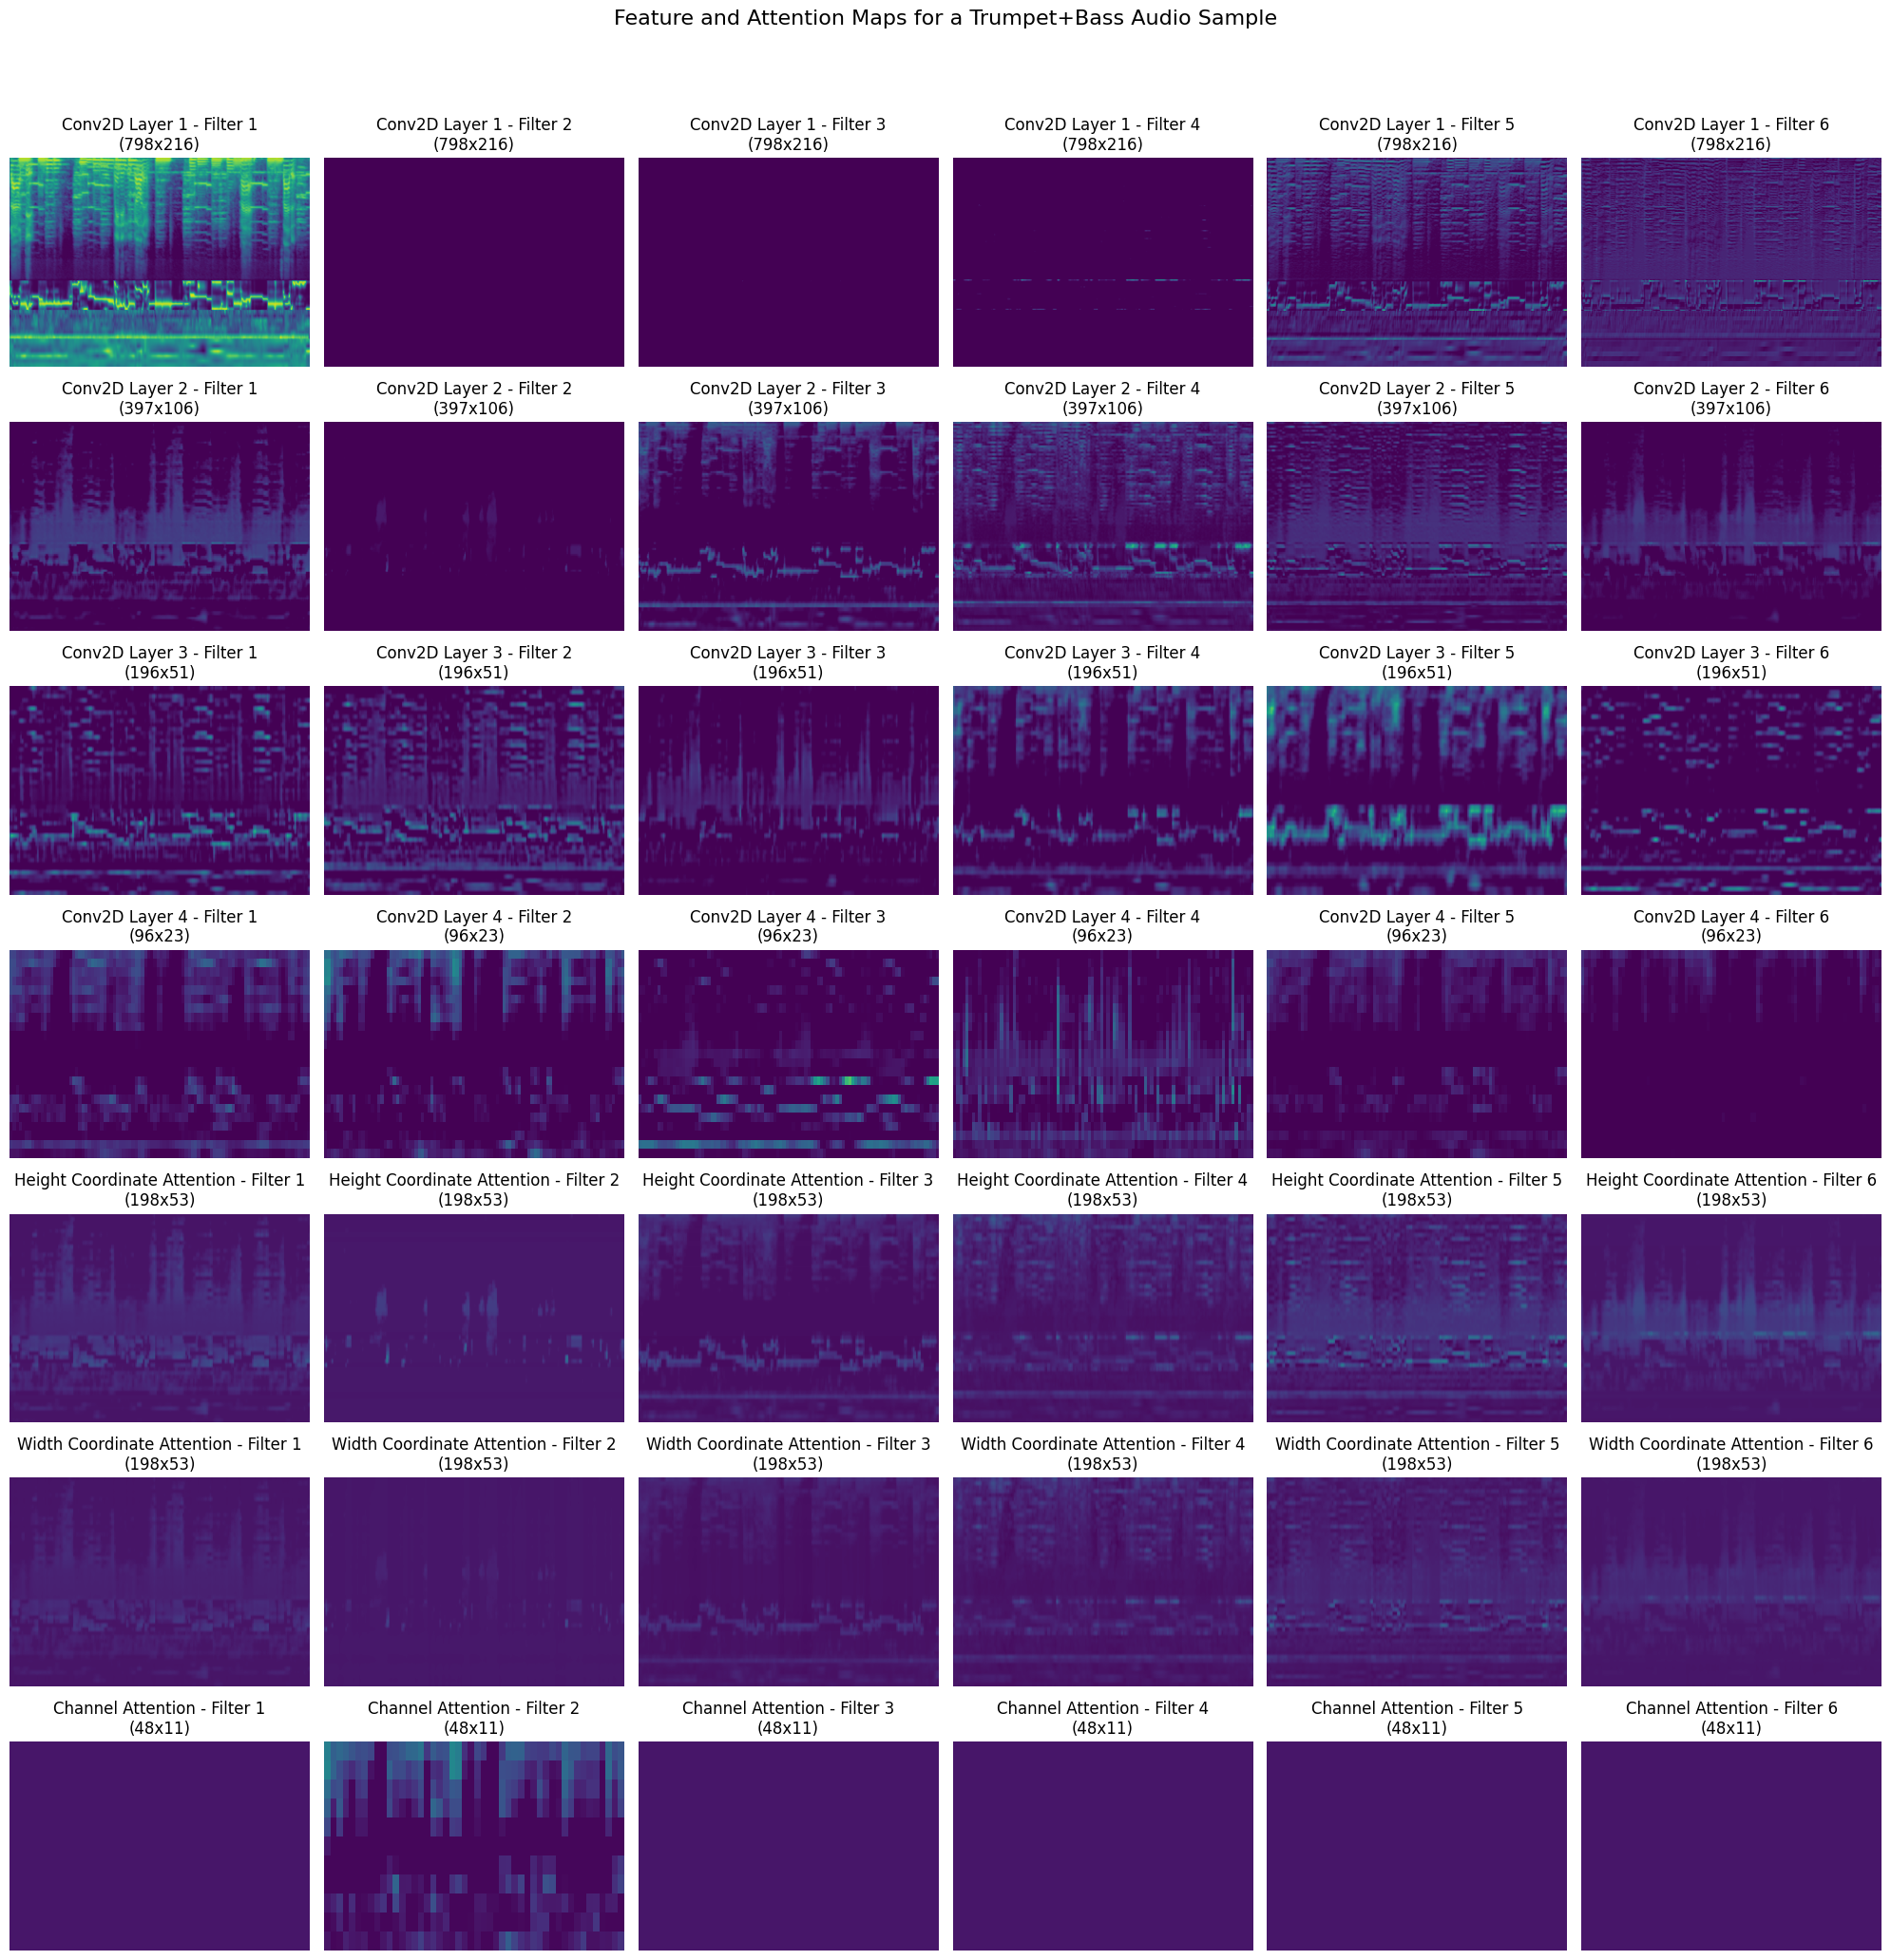

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

"""
def plot_feature_and_attention_maps(model, x_data, sample_index=0):
    conv_output, height_attention, width_attention = model.predict(np.expand_dims(x_data[sample_index], axis=0))

    plt.figure(figsize=(20, 15))

    # Overall title
    plt.suptitle('Feature and Attention Maps for a Saxophone+Trumpet+Trombone Audio Sample', fontsize=16)

    # Plotting the convolutional layer output
    num_filters = conv_output.shape[-1]
    vmin, vmax = conv_output.min(), conv_output.max()
    for i in range(min(num_filters, 6)):  # Limiting to first 6 filters for visualization
        plt.subplot(3, 6, i + 1)
        plt.title(f'Conv2D Output Filter {i+1}')
        plt.imshow(conv_output[0, :, :, i], aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
        plt.colorbar()

    # Plotting the height coordinate attention
    plt.subplot(3, 6, 7)
    plt.title('Height Coordinate Attention')
    height_att_map = np.mean(height_attention.squeeze(), axis=-1)
    plt.imshow(height_att_map, aspect='auto', cmap='viridis')
    plt.colorbar()

    # Plotting the width coordinate attention
    plt.subplot(3, 6, 8)
    plt.title('Width Coordinate Attention')
    width_att_map = np.mean(width_attention.squeeze(), axis=-1)
    plt.imshow(width_att_map, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()

# Use the function
plot_feature_and_attention_maps(visualization_model, X_test, sample_index=20)

def plot_attention_maps(model, x_data, sample_index=0):
    channel_attention, height_attention, width_attention = model.predict(np.expand_dims(x_data[sample_index], axis=0))

    plt.figure(figsize=(20, 5))
    plt.suptitle('A saxophone+trumpet+trombone Audio Sample', fontsize=16)

    plt.subplot(1, 4, 1)
    plt.title('Original Spectrogram')
    plt.imshow(x_data[sample_index].squeeze(), aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title('Channel Attention')
    channel_att_map = np.mean(channel_attention.squeeze(), axis=-1)
    plt.imshow(channel_att_map, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.title('Height Coordinate Early Attention')
    height_att_map = np.mean(height_attention.squeeze(), axis=-1)
    plt.imshow(height_att_map, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title('Width Coordinate Early Attention')
    width_att_map = np.mean(width_attention.squeeze(), axis=-1)
    plt.imshow(width_att_map, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

def plot_attention_maps(model, x_data, sample_index=0):
    channel_attention, height_attention, width_attention = model.predict(np.expand_dims(x_data[sample_index], axis=0))

    plt.figure(figsize=(20, 5))
    plt.suptitle('A saxophone+trumpet+trombone Audio Sample', fontsize=16)

    plt.subplot(1, 3, 1)
    plt.title('Original Spectrogram')
    plt.imshow(x_data[sample_index].squeeze(), aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title('Height Coordinate Early Attention')
    height_att_map = np.mean(height_attention.squeeze(), axis=-1)
    plt.imshow(height_att_map, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title('Width Coordinate Early Attention')
    width_att_map = np.mean(width_attention.squeeze(), axis=-1)
    plt.imshow(width_att_map, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.tight_layout()
    plt.show()
"""
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_and_attention_maps(model, x_data, sample_index=0):
    outputs = model.predict(np.expand_dims(x_data[sample_index], axis=0))

    layer_names = [
        'Conv2D Layer 1', 'Conv2D Layer 2', 'Conv2D Layer 3', 'Conv2D Layer 4',
        'Height Coordinate Attention', 'Width Coordinate Attention', 'Channel Attention'
    ]

    num_layers = len(outputs)
    num_filters_to_show = 6  # Number of filters to show for each layer

    plt.figure(figsize=(20, num_layers * 3))

    # Overall title
    plt.suptitle('Feature and Attention Maps for a Trumpet+Bass Audio Sample', fontsize=16)

    for i, output in enumerate(outputs):
        num_filters = output.shape[-1]
        height, width = output.shape[1], output.shape[2] if len(output.shape) == 4 else (output.shape[1], output.shape[2])
        vmin, vmax = output.min(), output.max()
        for j in range(min(num_filters, num_filters_to_show)):
            plt.subplot(num_layers, num_filters_to_show, i * num_filters_to_show + j + 1)
            if len(output.shape) == 4:  # Conv2D outputs
                plt.title(f'{layer_names[i]} - Filter {j+1}\n({width}x{height})')
                plt.imshow(output[0, :, :, j], aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
                plt.axis('off')
            else:  # Attention outputs (2D)
                plt.title(f'{layer_names[i]}\n({width}x{height})')
                plt.imshow(np.mean(output.squeeze(), axis=-1), aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
                plt.colorbar()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()

# Use the function
plot_feature_and_attention_maps(visualization_model, X_test, sample_index=9)



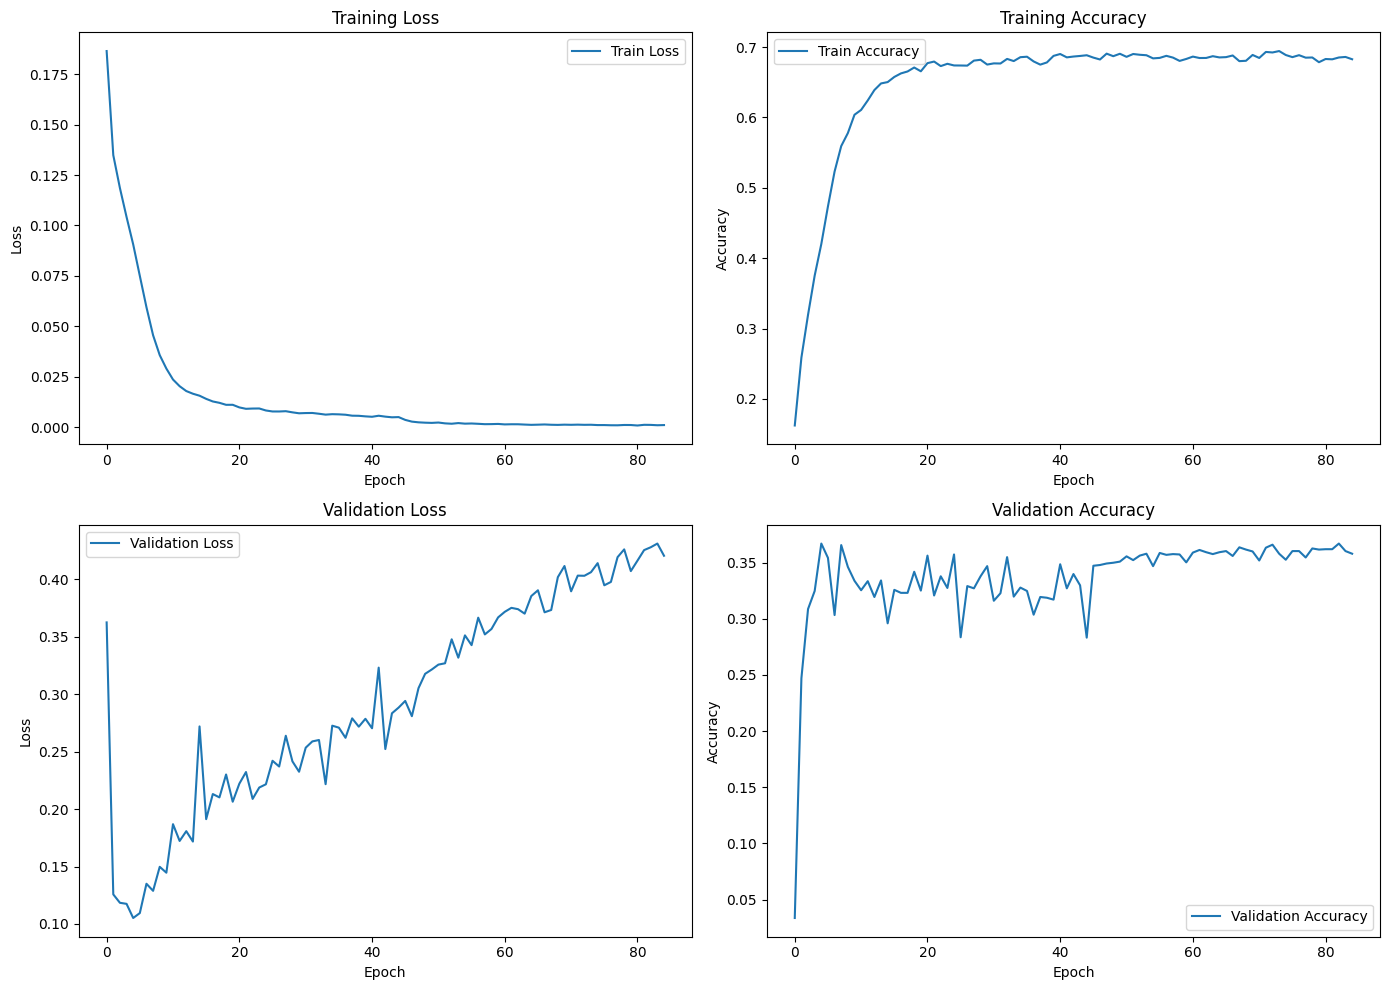

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
history_df = pd.read_csv('/content/drive/My Drive/datasets/openmic-2018/training_history_with_attention.csv')

# Plotting the training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plotting Training Loss
axes[0, 0].plot(history_df['loss'], label='Train Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plotting Training Accuracy
axes[0, 1].plot(history_df['accuracy'], label='Train Accuracy')
axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plotting Validation Loss
axes[1, 0].plot(history_df['val_loss'], label='Validation Loss')
axes[1, 0].set_title('Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Plotting Validation Accuracy
axes[1, 1].plot(history_df['val_accuracy'], label='Validation Accuracy')
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()
